# Libraries

In [2]:
#importing libraries
import pandas as pd
pd.set_option("display.max_columns",None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
sns.set_palette('rocket')
from time import time
import pingouin
from scipy.stats import ttest_ind
from datasist.structdata import detect_outliers
from geopy.distance import great_circle
from category_encoders import WOEEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Collect Data

In [4]:
train=pd.read_csv("fraudTrain.csv")
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
test=pd.read_csv('fraudTest.csv')
test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [6]:
#this test data also contains is_fraud it's not seperated to our test model
#so we will concat them together to clean them,then make our predictions on test data without is_fraud

In [7]:
train['split']='train'
test['split']='test'
df=pd.concat([train,test],axis=0).reset_index(drop=True)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,split
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,train
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,train
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,train


# Data Preprocessing

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [10]:
#check NUllS
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
split                    0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'split'],
      dtype='object')

In [13]:
#drop unnecessary columns 
#we will drop customer location and merchant
#we will drop location of customer as we will get the distance of between
df.drop(columns=['Unnamed: 0','street','state','first','last','trans_num','unix_time'],inplace=True)

In [14]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,split
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,train
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0,train
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,train
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0,train
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0,train


In [15]:
#change Date type
df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'],format='mixed')

In [16]:
df['hour']=df['trans_date_trans_time'].dt.hour
df['day']=df['trans_date_trans_time'].dt.day_name()
df['month']=df['trans_date_trans_time'].dt.month

In [17]:
#clean merchant column
df['merchant']=df['merchant'].apply(lambda x : x.replace('fraud_',""))

In [18]:
df[['merchant']].head()

,merchant
0,"Rippin, Kub and Mann"
1,"Heller, Gutmann and Zieme"
2,Lind-Buckridge
3,"Kutch, Hermiston and Farrell"
4,Keeling-Crist


In [19]:
#date of birth => age of customer
df['dob']=pd.to_datetime(df['dob'],format='mixed')
df['age']=(df['trans_date_trans_time'].dt.year-df['dob'].dt.year).astype(int)

In [20]:
#location between customer and merchant
df['distance_km']=df.apply(lambda col : round(great_circle((col['lat'],col['long']),(col['merch_lat'],col['merch_long'])).kilometers,2),axis=1)


In [21]:
df.drop(columns=['dob','lat','long','merch_long','merch_lat'],inplace=True)

In [22]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,is_fraud,split,hour,day,month,age,distance_km
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,3495,"Psychologist, counselling",0,train,0,Tuesday,1,31,78.60
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,149,Special educational needs teacher,0,train,0,Tuesday,1,41,30.21
2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,Malad City,83252,4154,Nature conservation officer,0,train,0,Tuesday,1,57,108.21
3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,1939,Patent attorney,0,train,0,Tuesday,1,52,95.67
4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,99,Dance movement psychotherapist,0,train,0,Tuesday,1,33,77.56


# EDA

In [24]:
#SUMMARY STATS
df.describe().T

,count,mean,min,25%,50%,75%,max,std
trans_date_trans_time,1852394,2020-01-20 21:31:46.801827328,2019-01-01 00:00:18,2019-07-23 04:13:43.750000128,2020-01-02 01:15:31,2020-07-23 12:11:25.249999872,2020-12-31 23:59:34,NaN
cc_num,1852394.0,417386038393710400.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0,1309115265318020352.0
amt,1852394.0,70.063567,1.0,9.64,47.45,83.1,28948.9,159.253975
zip,1852394.0,48813.258191,1257.0,26237.0,48174.0,72042.0,99921.0,26881.845966
city_pop,1852394.0,88643.674509,23.0,741.0,2443.0,20328.0,2906700.0,301487.618344
is_fraud,1852394.0,0.00521,0.0,0.0,0.0,0.0,1.0,0.071992
hour,1852394.0,12.806119,0.0,7.0,14.0,19.0,23.0,6.815753
month,1852394.0,7.152067,1.0,4.0,7.0,10.0,12.0,3.424954
age,1852394.0,46.21138,14.0,33.0,44.0,57.0,96.0,17.395446
distance_km,1852394.0,76.111833,0.02,55.32,78.22,98.51,152.12,29.117007


In [25]:
df.describe(include='object').T

,count,unique,top,freq
merchant,1852394,693,Kilback LLC,6262
category,1852394,14,gas_transport,188029
gender,1852394,2,F,1014749
city,1852394,906,Birmingham,8040
job,1852394,497,Film/video editor,13898
split,1852394,2,train,1296675
day,1852394,7,Monday,369418


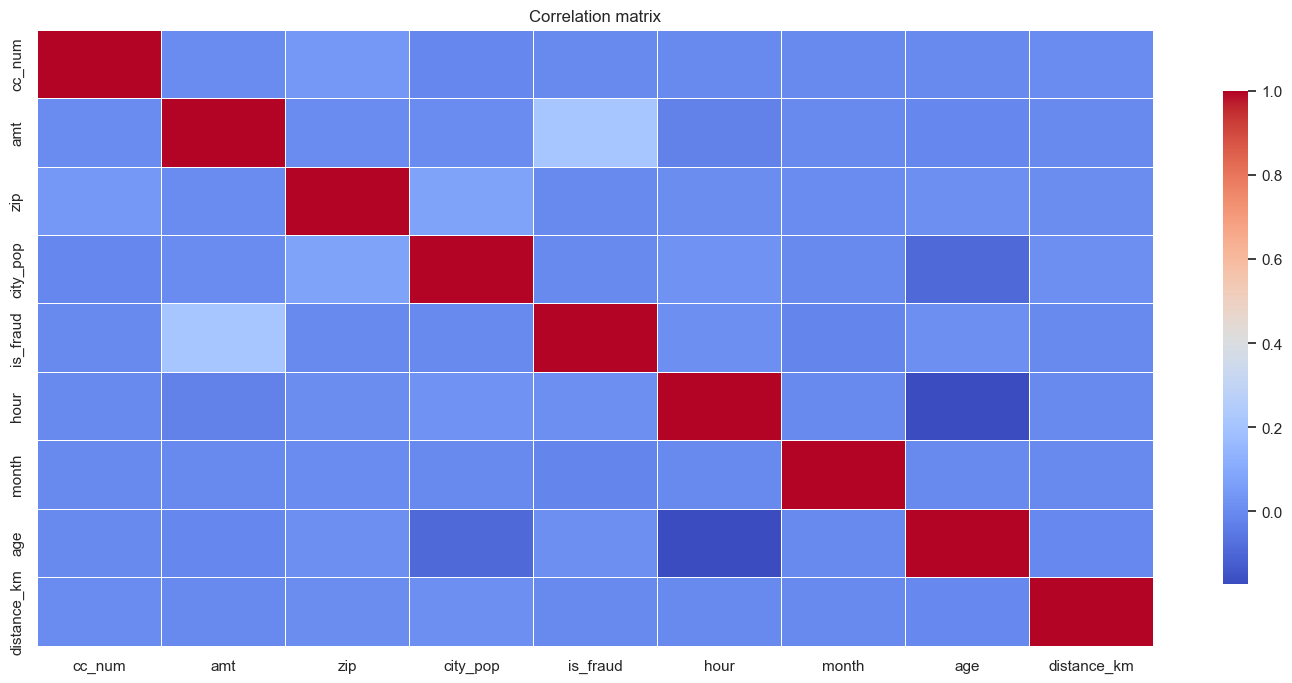

In [26]:
#check corr between numeric values
sns.heatmap(df.select_dtypes(include='number').corr(),annot=None,cmap='coolwarm',fmt='.2f',linewidths=0.5,cbar_kws={'shrink':0.8})
plt.title('Correlation matrix')
plt.show()

In [27]:
#we can't detect clear corr between features
df.select_dtypes(include='number').corr()

,cc_num,amt,zip,city_pop,is_fraud,hour,month,age,distance_km
cc_num,1.000000,0.001826,0.041504,-0.009118,-0.001125,-0.000902,-0.000188,-0.000131,0.003082
amt,0.001826,1.000000,0.001979,0.004921,0.209308,-0.024891,-0.002593,-0.010695,-0.000538
zip,0.041504,0.001979,1.000000,0.077601,-0.002190,0.005947,0.001160,0.010359,0.006750
city_pop,-0.009118,0.004921,0.077601,1.000000,0.000325,0.019949,-0.000510,-0.090889,0.010989
is_fraud,-0.001125,0.209308,-0.002190,0.000325,1.000000,0.013196,-0.016417,0.010927,0.000359
hour,-0.000902,-0.024891,0.005947,0.019949,0.013196,1.000000,-0.000986,-0.173014,0.000391
month,-0.000188,-0.002593,0.001160,-0.000510,-0.016417,-0.000986,1.000000,0.000060,-0.000067
age,-0.000131,-0.010695,0.010359,-0.090889,0.010927,-0.173014,0.000060,1.000000,-0.004155
distance_km,0.003082,-0.000538,0.006750,0.010989,0.000359,0.000391,-0.000067,-0.004155,1.000000


### get in depth in data

In [29]:
#function to visualize the determined data
def bar_plot(col):
    def top_fraud(col):
        return pd.DataFrame(df.loc[df['is_fraud']==1,[col]].value_counts()).reset_index().head(10)
    ax=sns.barplot(data=top_fraud(col),x=col,y='count',palette='bone')
    ax.bar_label=(ax.containers[0])
    plt.title(f'TOP 10 FRAUDS | {col}',fontsize=16,fontweight='bold')
    plt.xticks(rotation=45,fontweight='bold')
    

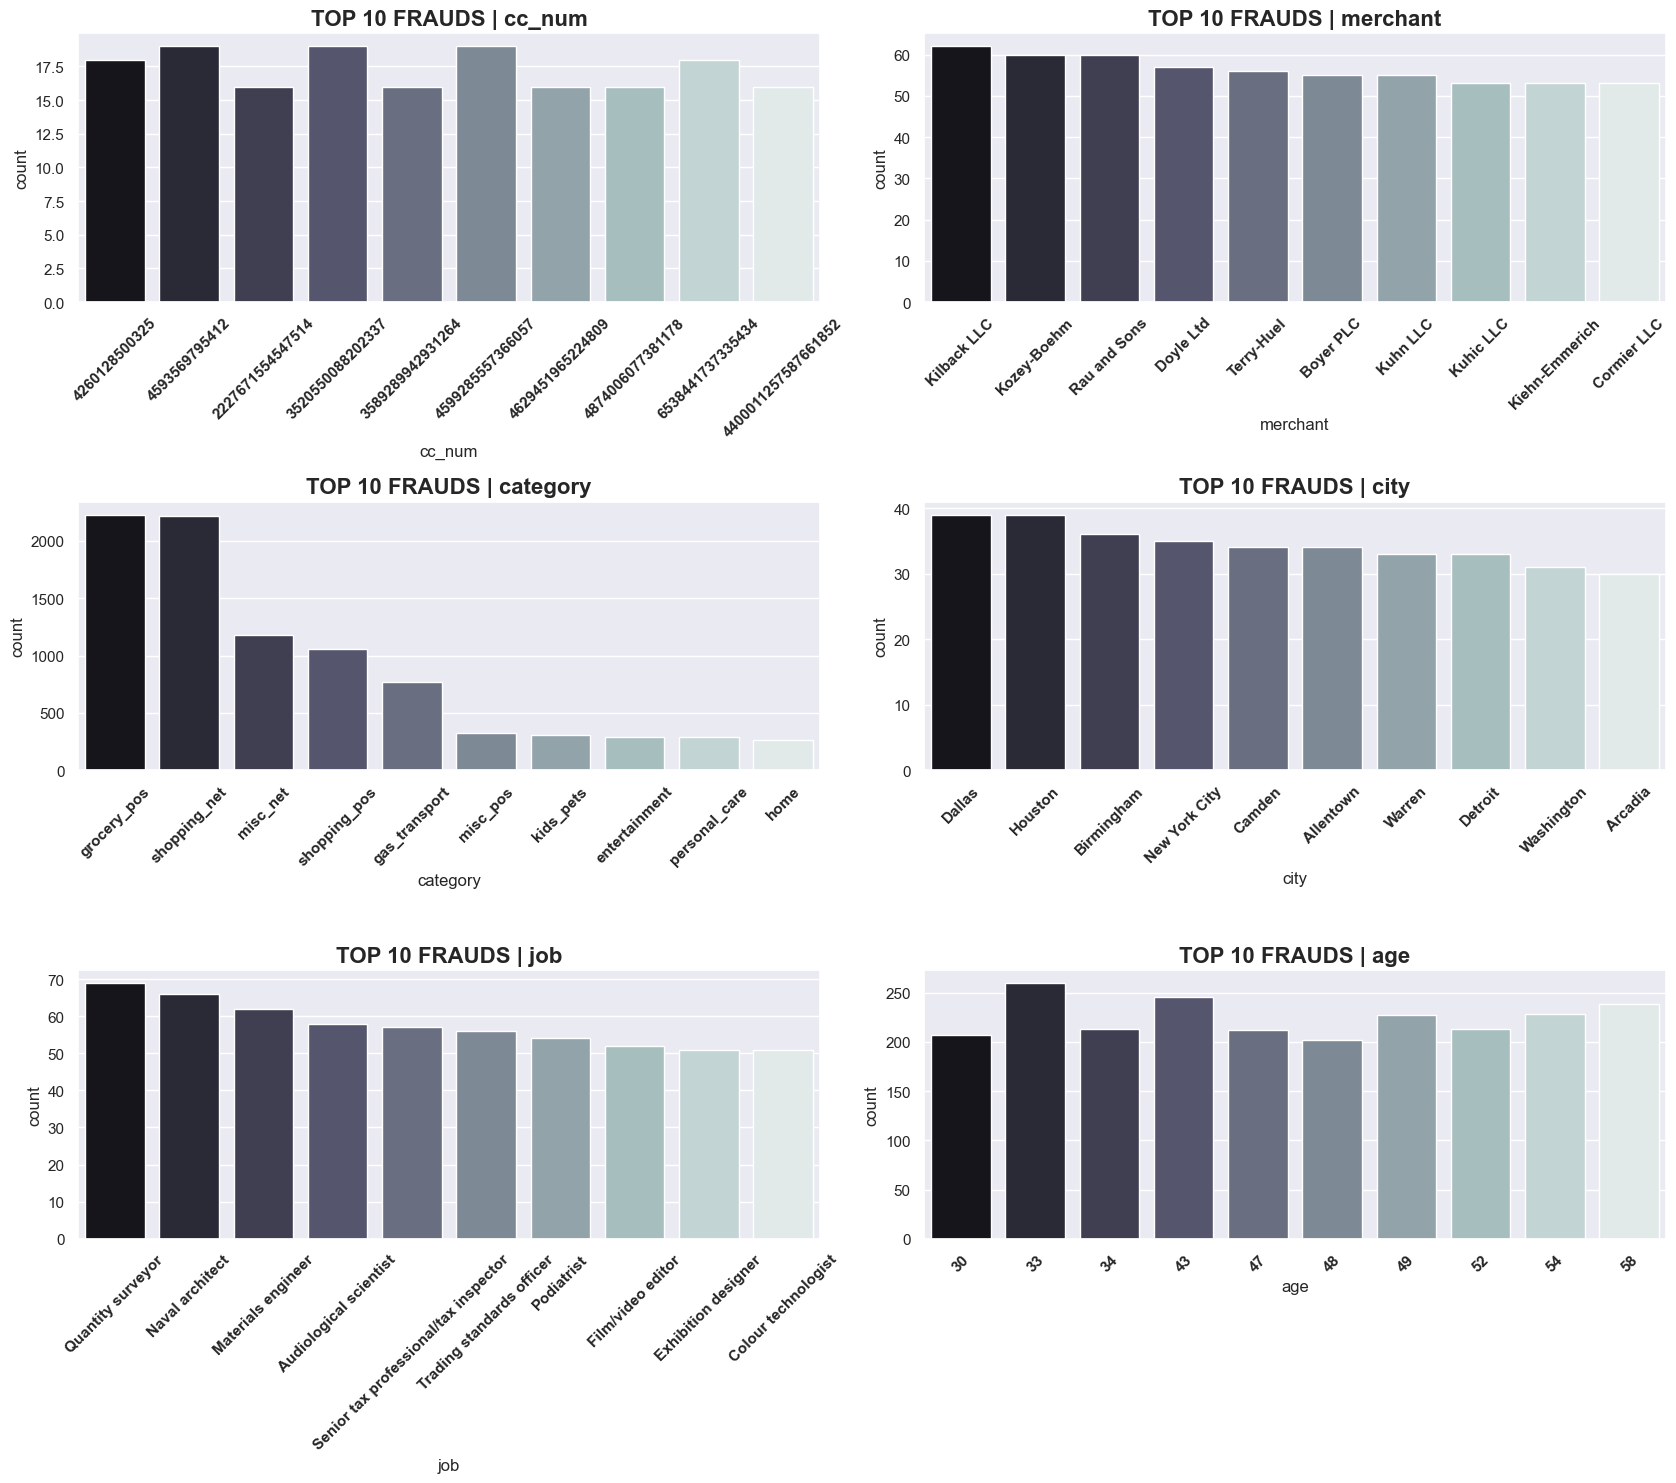

In [30]:
plt.figure(figsize=(17,15))
for idx,val in enumerate(['cc_num','merchant','category','city','job','age']):
    plt.subplot(3,2,idx+1)
    bar_plot(val)
plt.tight_layout()

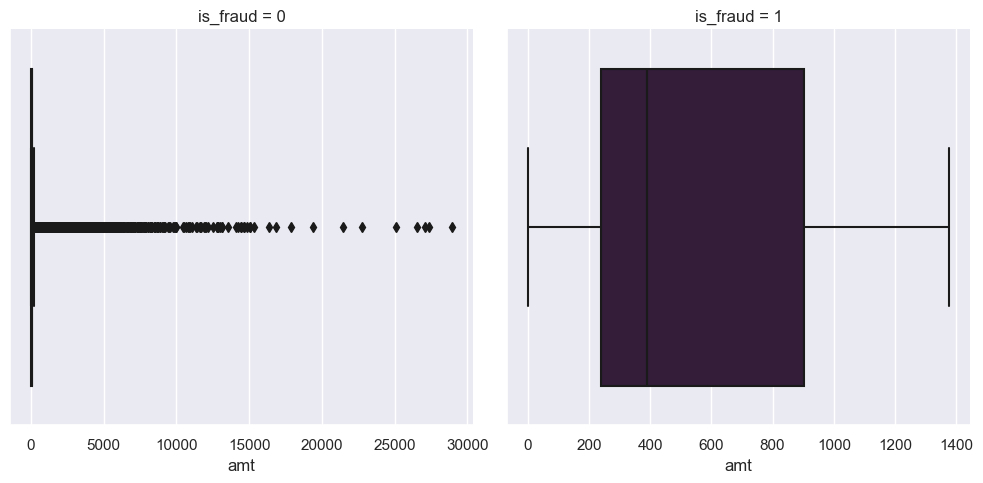

In [31]:
sns.catplot(data=df,x='amt',col='is_fraud',kind='box',sharex=False)

In [32]:
#we detect huge number of outliers in the amts of genuine transactions 
#we will handle that using the scaling process
#since we can't remove them
#Because they represent the real data


gender
F    1014749
M     837645
Name: count, dtype: int64


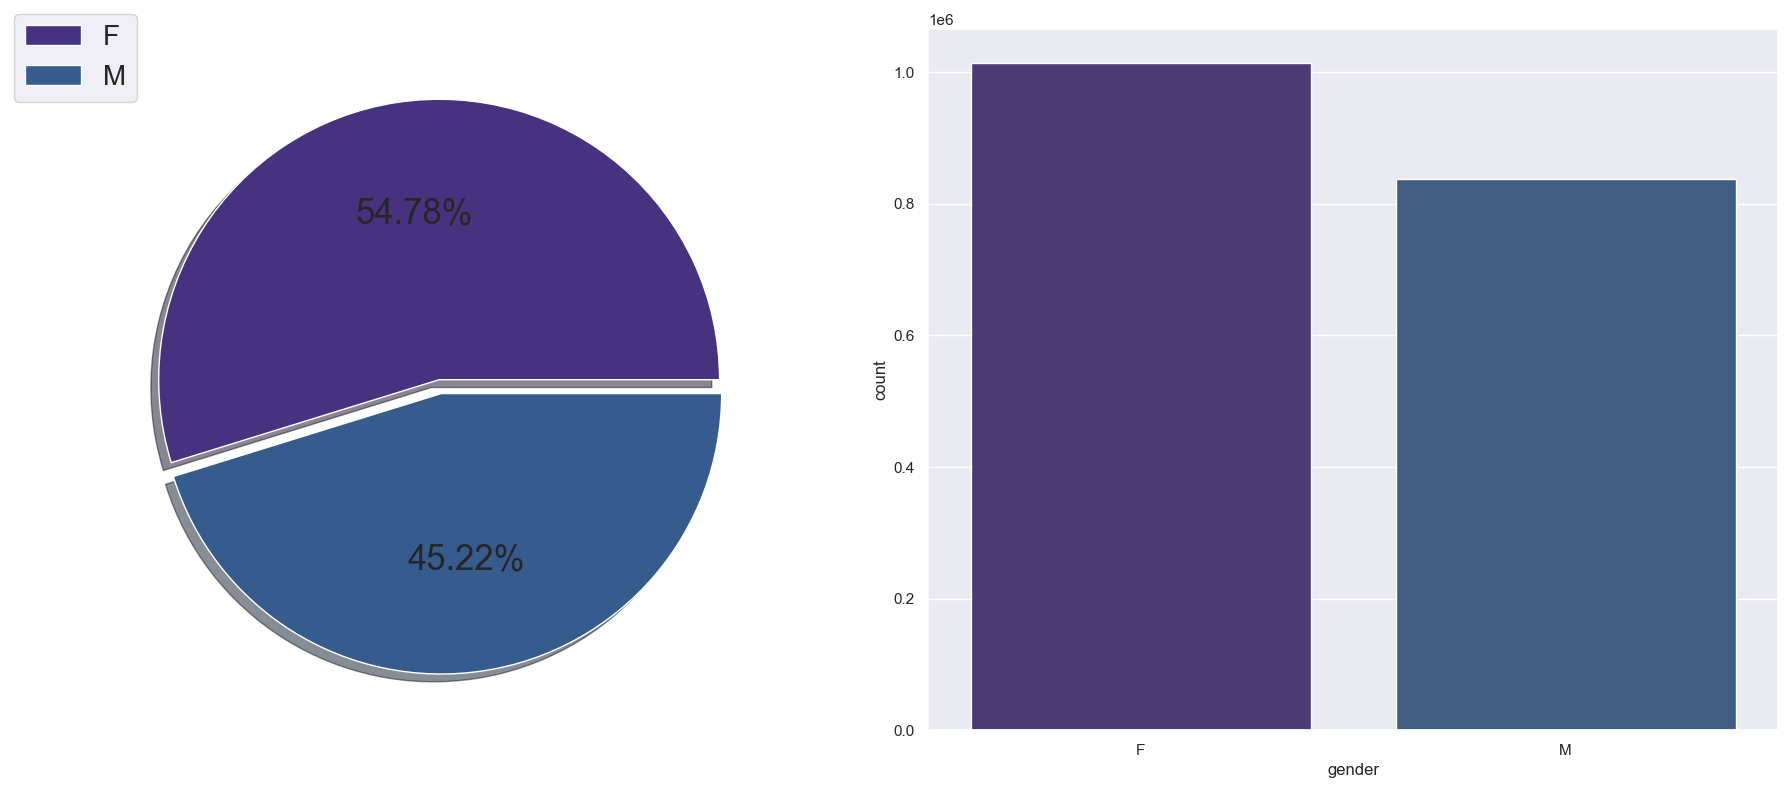

In [33]:
def pie_bar_plot(col):
    print(df[col].value_counts())
    sns.set_palette('viridis')
    fig,axs=plt.subplots(1,2)
    axs[0].pie(df[col].value_counts().values.tolist(),autopct='%.2f%%',textprops={'fontsize':25},explode=[0,0.05],shadow=True)
    sns.countplot(data=df,x=col,ax=axs[1])
    fig.legend(labels=df[col].value_counts().index.tolist(),loc='upper left',fontsize=20)
    fig.tight_layout()
    fig.show()
pie_bar_plot('gender')

is_fraud
0    1842743
1       9651
Name: count, dtype: int64


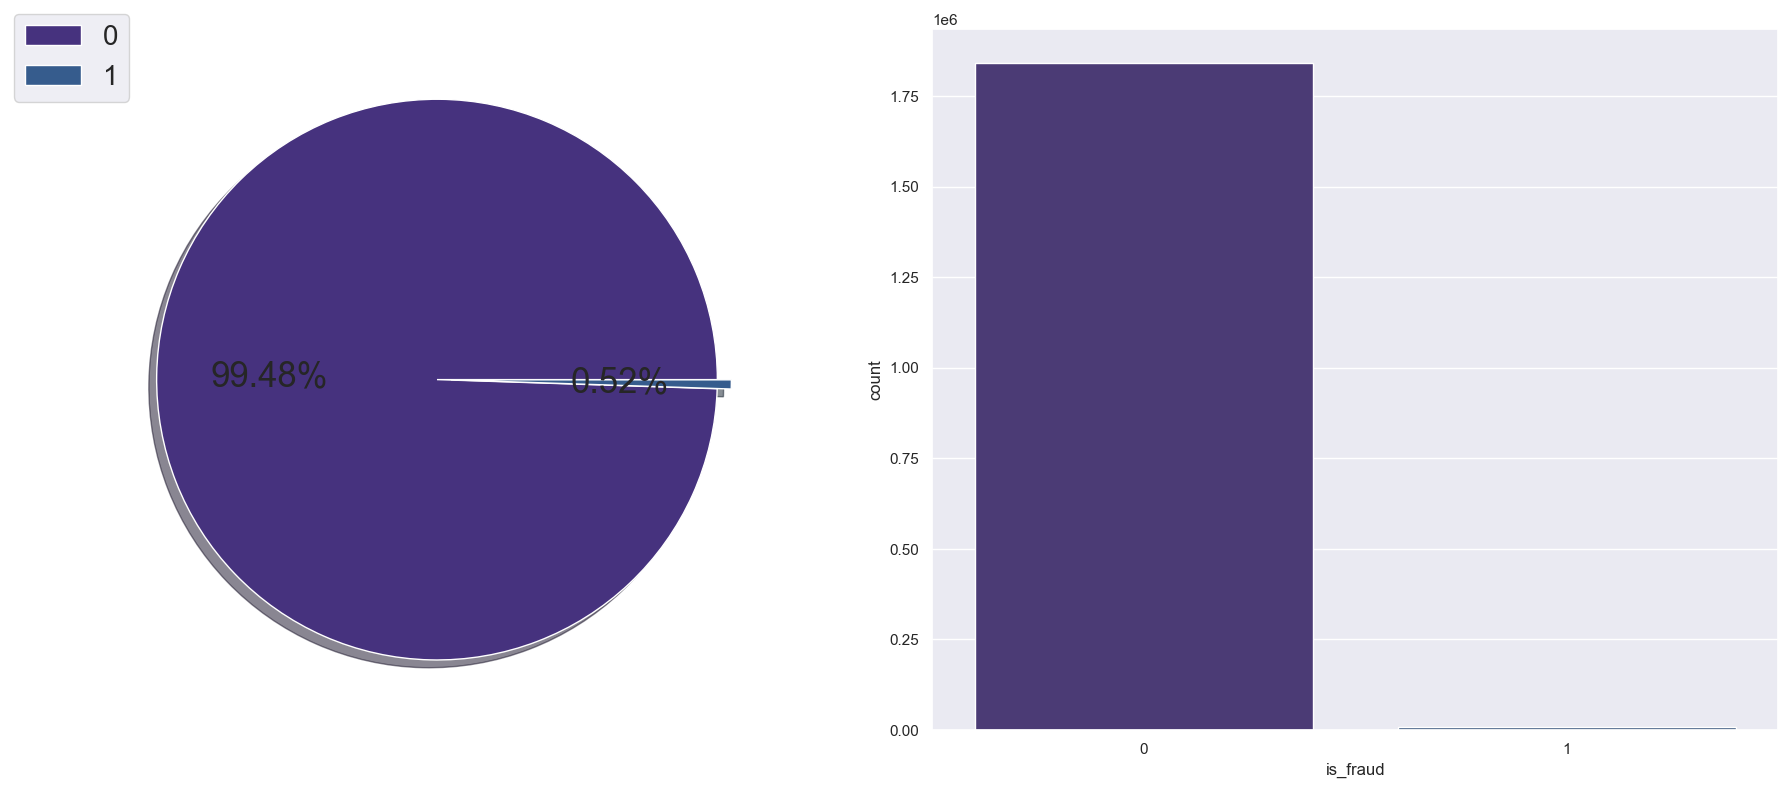

In [34]:
pie_bar_plot('is_fraud')

In [35]:
#we discovered the fraud column is imbalanced
#so we will fix it later

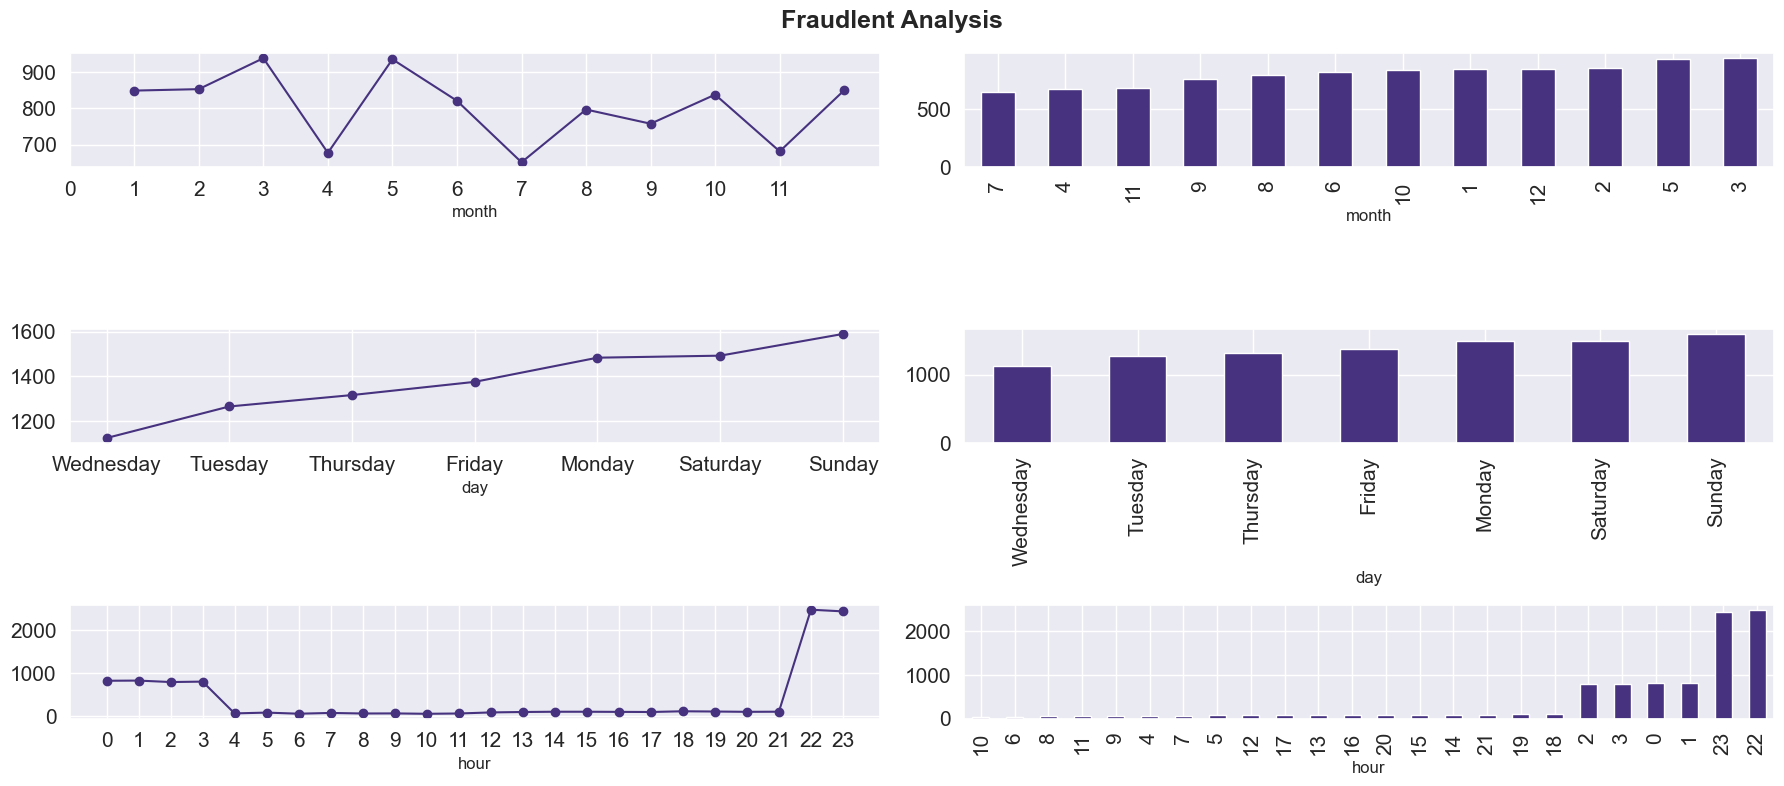

In [36]:
fig,axs=plt.subplots(3,2)
#month
df.loc[df['is_fraud']==1,'month'].value_counts().sort_index().plot(kind='line',ax=axs[0,0],marker='o',fontsize=15)
axs[0,0].set_xticks(range(0,12))
df.loc[df['is_fraud']==1,'month'].value_counts(ascending=True).plot(kind='bar',ax=axs[0,1],fontsize=15)
fig.suptitle('Fraudulent Analysis',fontsize=18,fontweight='bold')
#day
df.loc[df['is_fraud']==1,'day'].value_counts(ascending=True).plot(kind='line',ax=axs[1,0],marker='o',fontsize=15)
df.loc[df['is_fraud']==1,'day'].value_counts(ascending=True).plot(kind='bar',ax=axs[1,1],fontsize=15)
#hour
df.loc[df['is_fraud']==1,'hour'].value_counts().sort_index().plot(kind='line',ax=axs[2,0],marker='o',fontsize=15)
axs[2,0].set_xticks(range(0,24))
df.loc[df['is_fraud']==1,'hour'].value_counts(ascending=True).plot(kind='bar',ax=axs[2,1],fontsize=15)
fig.suptitle('Fraudlent Analysis',fontsize=18,fontweight='bold')
plt.tight_layout()

#### We conclude that most fraudulent activity's occurs:
- On March
- On Sunday
- At 10 PM

In [38]:
df.loc[df['is_fraud']==1,['gender']].value_counts()
#male and female exposed to fraud equally [aproximately]

gender
F         4899
M         4752
Name: count, dtype: int64

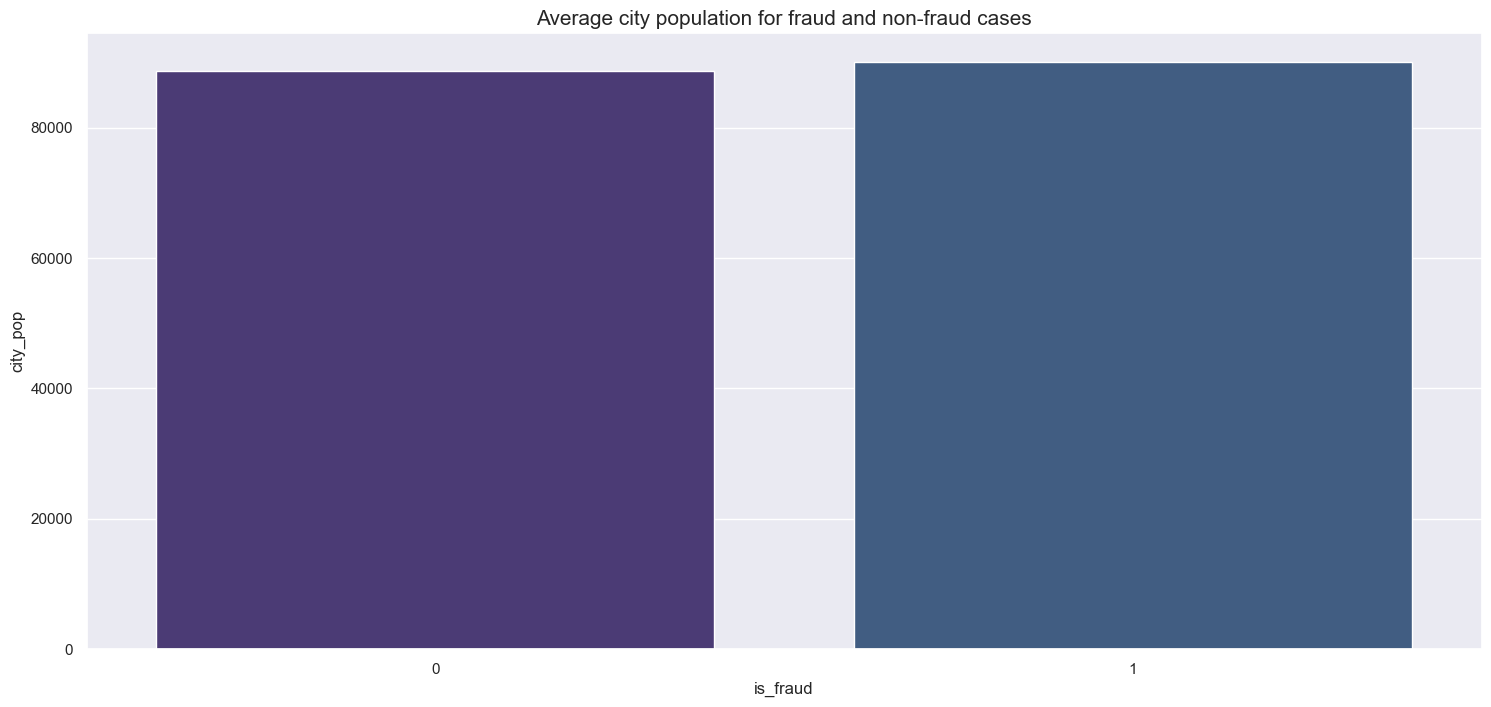

T-test: t-statistic = 0.443, p-value = 0.66, p-value<0.05? = False


In [39]:
sns.barplot(data=df,x='is_fraud',y='city_pop',ci=None)
plt.title('Average city population for fraud and non-fraud cases',fontsize=15)
plt.show()
fraud_population=df[df['is_fraud']==1]['city_pop']
non_fraud_population=df[df['is_fraud']==0]['city_pop']
t_stat,p_value=ttest_ind(fraud_population,non_fraud_population)
print(f'T-test: t-statistic = {round(t_stat,3)}, p-value = {round(p_value,2)}, p-value<0.05? = {p_value<0.05}')

In [40]:
#since we accept the null hypothesis,we conclude that ther is no significant difference between means
#so,we conclude also that city_pop does not help us on the target ('is_fraud'),so we wiil drop it

# Further preprocessing

In [42]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,is_fraud,split,hour,day,month,age,distance_km
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,3495,"Psychologist, counselling",0,train,0,Tuesday,1,31,78.60
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,149,Special educational needs teacher,0,train,0,Tuesday,1,41,30.21
2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,Malad City,83252,4154,Nature conservation officer,0,train,0,Tuesday,1,57,108.21
3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,1939,Patent attorney,0,train,0,Tuesday,1,52,95.67
4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,99,Dance movement psychotherapist,0,train,0,Tuesday,1,33,77.56


In [43]:
#convert gender into binary classification
df=pd.get_dummies(df,columns=['gender'],drop_first=True)

In [44]:
#we will get the time between transactions for each card
#Time=0 for every first transaction and time will be represented in hours.
df.sort_values(['cc_num','trans_date_trans_time'],inplace=True)
df['hours_diff_bet_trans']=((df.groupby('cc_num')[['trans_date_trans_time']].diff())/np.timedelta64(1,'h'))

In [45]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,city,zip,city_pop,job,is_fraud,split,hour,day,month,age,distance_km,gender_M,hours_diff_bet_trans
1017,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,Fort Washakie,82514,1645,Information systems manager,0,train,12,Tuesday,1,33,127.61,False,NaN
2724,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,Fort Washakie,82514,1645,Information systems manager,0,train,8,Wednesday,1,33,110.31,False,19.961667
2726,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,Fort Washakie,82514,1645,Information systems manager,0,train,8,Wednesday,1,33,21.79,False,0.044167
2882,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,Fort Washakie,82514,1645,Information systems manager,0,train,12,Wednesday,1,33,87.20,False,3.843889
2907,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,Fort Washakie,82514,1645,Information systems manager,0,train,13,Wednesday,1,33,74.21,False,0.542222


In [46]:
df.loc[df['hours_diff_bet_trans'].isna(),'hours_diff_bet_trans']=0
df['hours_diff_bet_trans']=df['hours_diff_bet_trans'].astype(int)

In [47]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,city,zip,city_pop,job,is_fraud,split,hour,day,month,age,distance_km,gender_M,hours_diff_bet_trans
1017,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,Fort Washakie,82514,1645,Information systems manager,0,train,12,Tuesday,1,33,127.61,False,0
2724,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,Fort Washakie,82514,1645,Information systems manager,0,train,8,Wednesday,1,33,110.31,False,19
2726,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,Fort Washakie,82514,1645,Information systems manager,0,train,8,Wednesday,1,33,21.79,False,0
2882,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,Fort Washakie,82514,1645,Information systems manager,0,train,12,Wednesday,1,33,87.20,False,3
2907,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,Fort Washakie,82514,1645,Information systems manager,0,train,13,Wednesday,1,33,74.21,False,0


                T          p-val
T-test  27.266899  7.200860e-158


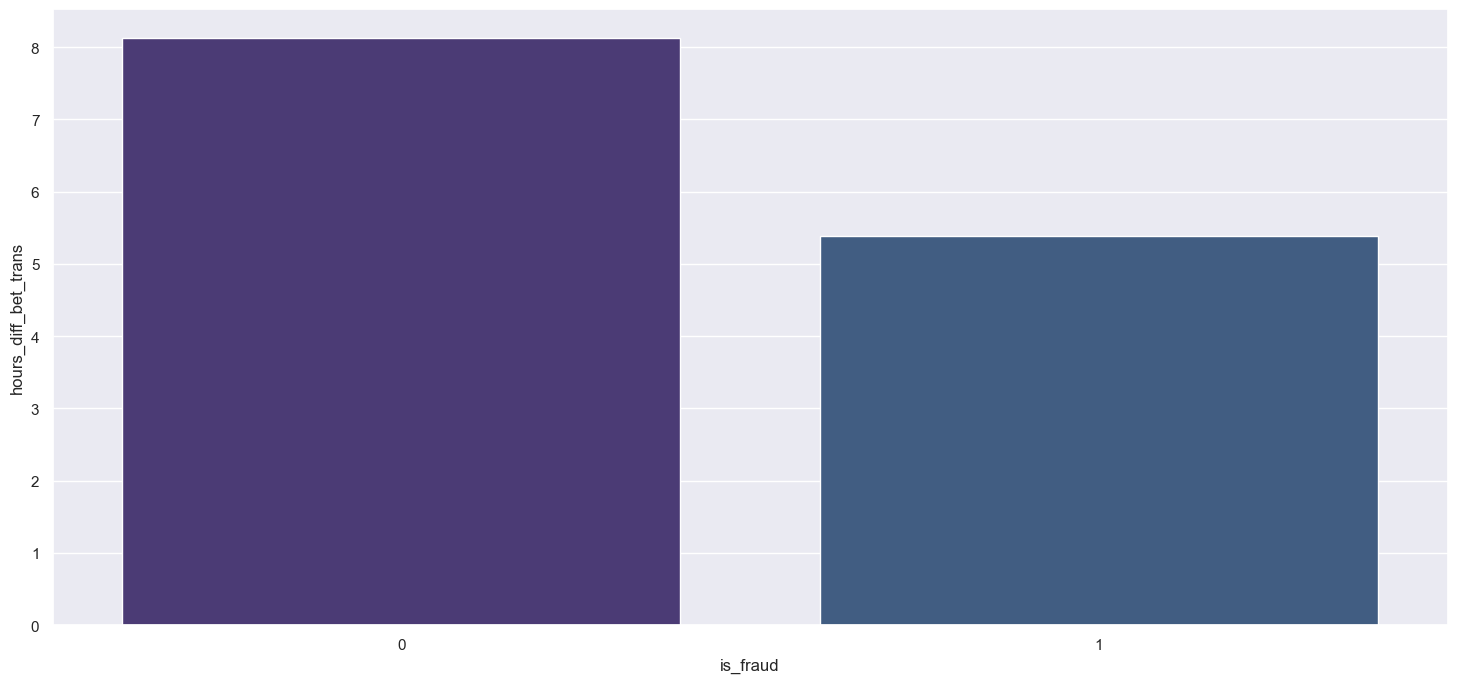

In [48]:
print(pingouin.ttest(df[df['is_fraud']==0]['hours_diff_bet_trans'],df[df['is_fraud']==1]['hours_diff_bet_trans'],alternative='two-sided')[['T','p-val']])
sns.barplot(data=df,x='is_fraud',y='hours_diff_bet_trans',ci=None)
plt.show()

In [49]:
#since p-value<0.05 , we reject the null hypothesis


In [50]:
#make day feature numerical
df['day']=df['trans_date_trans_time'].dt.weekday

In [51]:
#handling and extracting features from cc_num
freq=df.groupby('cc_num').size()
df['cc_freq']=df['cc_num'].apply(lambda x:freq[x])
df[['cc_num','cc_freq']].head()

,cc_num,cc_freq
1017,60416207185,2196
2724,60416207185,2196
2726,60416207185,2196
2882,60416207185,2196
2907,60416207185,2196


In [52]:
#we got freq for each cc numbers
def his_show(col):
    fig,axs=plt.subplots(1,2,sharex=True)
    for i in [0,1]:
        sns.histplot(df[df['is_fraud']==i][col],bins=6,ax=axs[i])
        

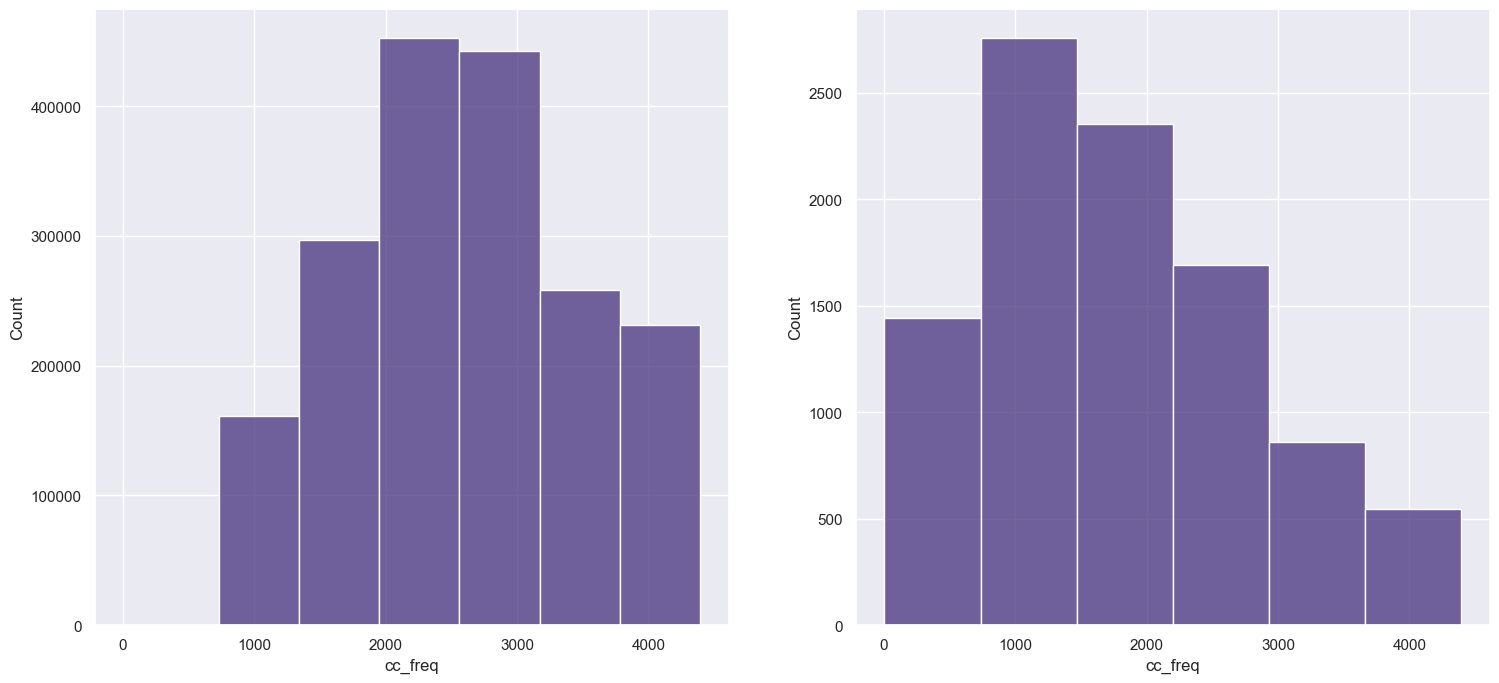

In [53]:
his_show('cc_freq')

In [54]:
def class_det(x):
    for idx,val in enumerate(list(range(800,5000,800))):
        if x<val:
            return idx+1
        

In [55]:
df['cc_freq_class']=df['cc_freq'].apply(class_det)
print(df['cc_freq_class'].unique())

[3 1 2 4 5 6]


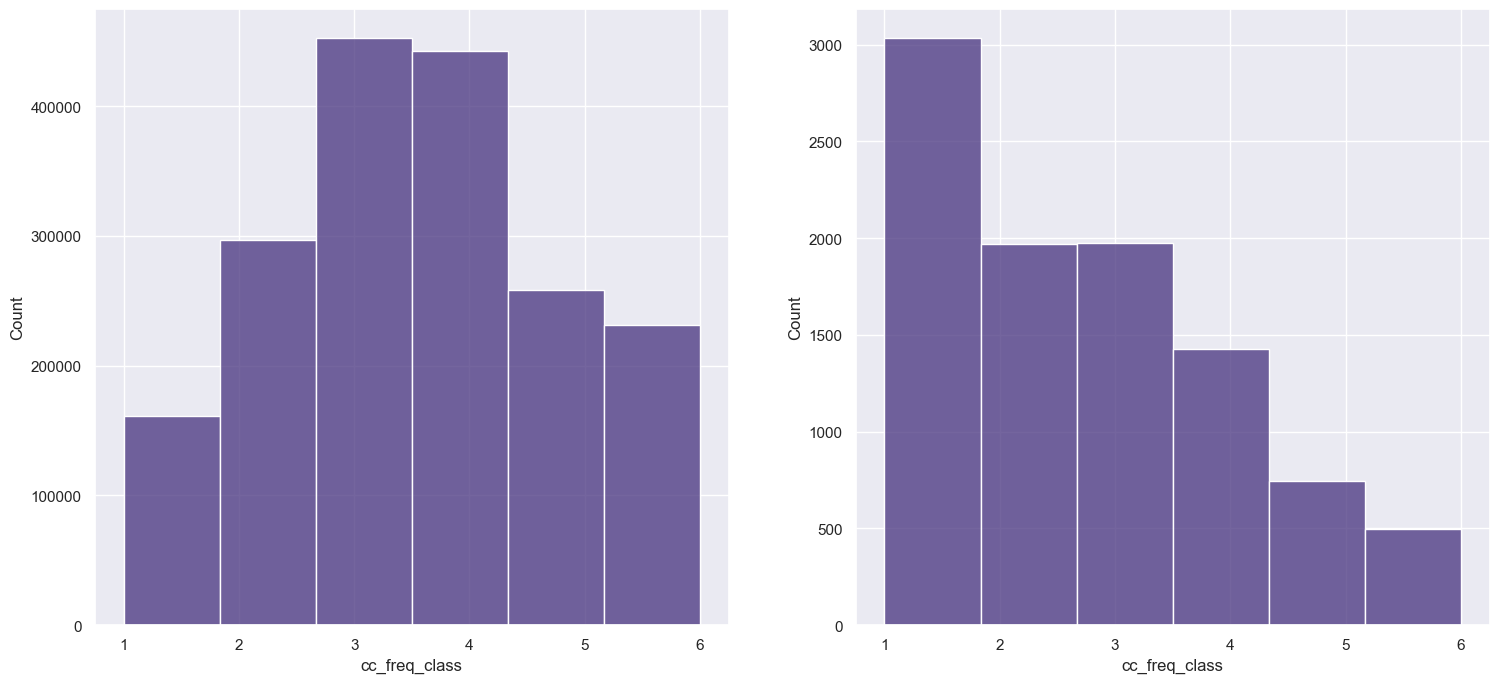

In [56]:
his_show('cc_freq_class')

#### Now clearly frauds occurs more in credit cards with less use(new ones) and for genuine transactions,it follows a normal distribution.

In [58]:
#drop unnecessary column
df.drop(columns=['cc_num','trans_date_trans_time','city_pop'],inplace=True)

In [59]:
df.columns

Index(['merchant', 'category', 'amt', 'city', 'zip', 'job', 'is_fraud',
       'split', 'hour', 'day', 'month', 'age', 'distance_km', 'gender_M',
       'hours_diff_bet_trans', 'cc_freq', 'cc_freq_class'],
      dtype='object')

In [60]:
#reorder columns
df=df[['cc_freq', 'cc_freq_class','city','job','age','gender_M','merchant','category','distance_km','month','day','month','hour','hours_diff_bet_trans','amt','is_fraud','split']]
df.head()

,cc_freq,cc_freq_class,city,job,age,gender_M,merchant,category,distance_km,month,day,month,hour,hours_diff_bet_trans,amt,is_fraud,split
1017,2196,3,Fort Washakie,Information systems manager,33,False,"Jones, Sawayn and Romaguera",misc_net,127.61,1,1,1,12,0,7.27,0,train
2724,2196,3,Fort Washakie,Information systems manager,33,False,Berge LLC,gas_transport,110.31,1,2,1,8,19,52.94,0,train
2726,2196,3,Fort Washakie,Information systems manager,33,False,Luettgen PLC,gas_transport,21.79,1,2,1,8,0,82.08,0,train
2882,2196,3,Fort Washakie,Information systems manager,33,False,Daugherty LLC,kids_pets,87.20,1,2,1,12,3,34.79,0,train
2907,2196,3,Fort Washakie,Information systems manager,33,False,Beier and Sons,home,74.21,1,2,1,13,0,27.18,0,train


In [61]:
# we will enocde ( city,job,merchant,category ) prepare for our model usinf WOEEncoder
for col in ['city','job','merchant','category']:
    df[col]=WOEEncoder().fit_transform(df[col],df['is_fraud'])

In [62]:
#WOE > 0 : the category is more likely associact with fraud
#WOE < 0 : the category is moer likely associated with non-fraud
df.head()

,cc_freq,cc_freq_class,city,job,age,gender_M,merchant,category,distance_km,month,day,month,hour,hours_diff_bet_trans,amt,is_fraud,split
1017,2196,3,-0.193426,0.163804,33,False,0.472059,0.925860,127.61,1,1,1,12,0,7.27,0,train
2724,2196,3,-0.193426,0.163804,33,False,-0.499771,-0.238221,110.31,1,2,1,8,19,52.94,0,train
2726,2196,3,-0.193426,0.163804,33,False,-0.132212,-0.238221,21.79,1,2,1,8,0,82.08,0,train
2882,2196,3,-0.193426,0.163804,33,False,-0.620062,-1.019735,87.20,1,2,1,12,3,34.79,0,train
2907,2196,3,-0.193426,0.163804,33,False,-1.296190,-1.238421,74.21,1,2,1,13,0,27.18,0,train


In [63]:
x_train=df[df['split']=='train'].drop(['split','is_fraud'],axis=1)
y_train=df[df['split']=='train']['is_fraud']
x_test=df[df['split']=='test'].drop(['split','is_fraud'],axis=1)
y_test=df[df['split']=='test']['is_fraud']


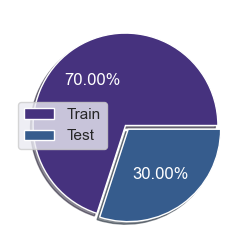

In [64]:
plt.figure(figsize=(3,3))
plt.pie([len(x_train),len(x_test)],autopct='%.2f%%',textprops={'color':'white'},explode=[0,0.05],shadow=True)
plt.legend(['Train','Test'])
plt.show()

In [65]:
# handling outliers
x_train.select_dtypes(include='number').columns

Index(['cc_freq', 'cc_freq_class', 'city', 'job', 'age', 'merchant',
       'category', 'distance_km', 'month', 'day', 'month', 'hour',
       'hours_diff_bet_trans', 'amt'],
      dtype='object')

In [66]:
#outliers in train data before scaling
def count_outliers(l:list):
    for col in l:
        print(f'Outliers In {col}:',len(detect_outliers(x_train,0,[col])))
    

In [67]:
def boxplot_outlier(ds:dict):
    plt.figure(figsize=(18,8))
    c=1
    for _,df_x in ds.items():
        for col in ['hours_diff_bet_trans','amt']:
            plt.subplot(2,2,c)
            df_x[col].plot(kind='box',vert=False)
            c+=1
    plt.suptitle('Detecting Outliers in Train|Test Data',fontsize=20)
    plt.tight_layout()

Outliers In hours_diff_bet_trans: 86989
Outliers In amt: 67290


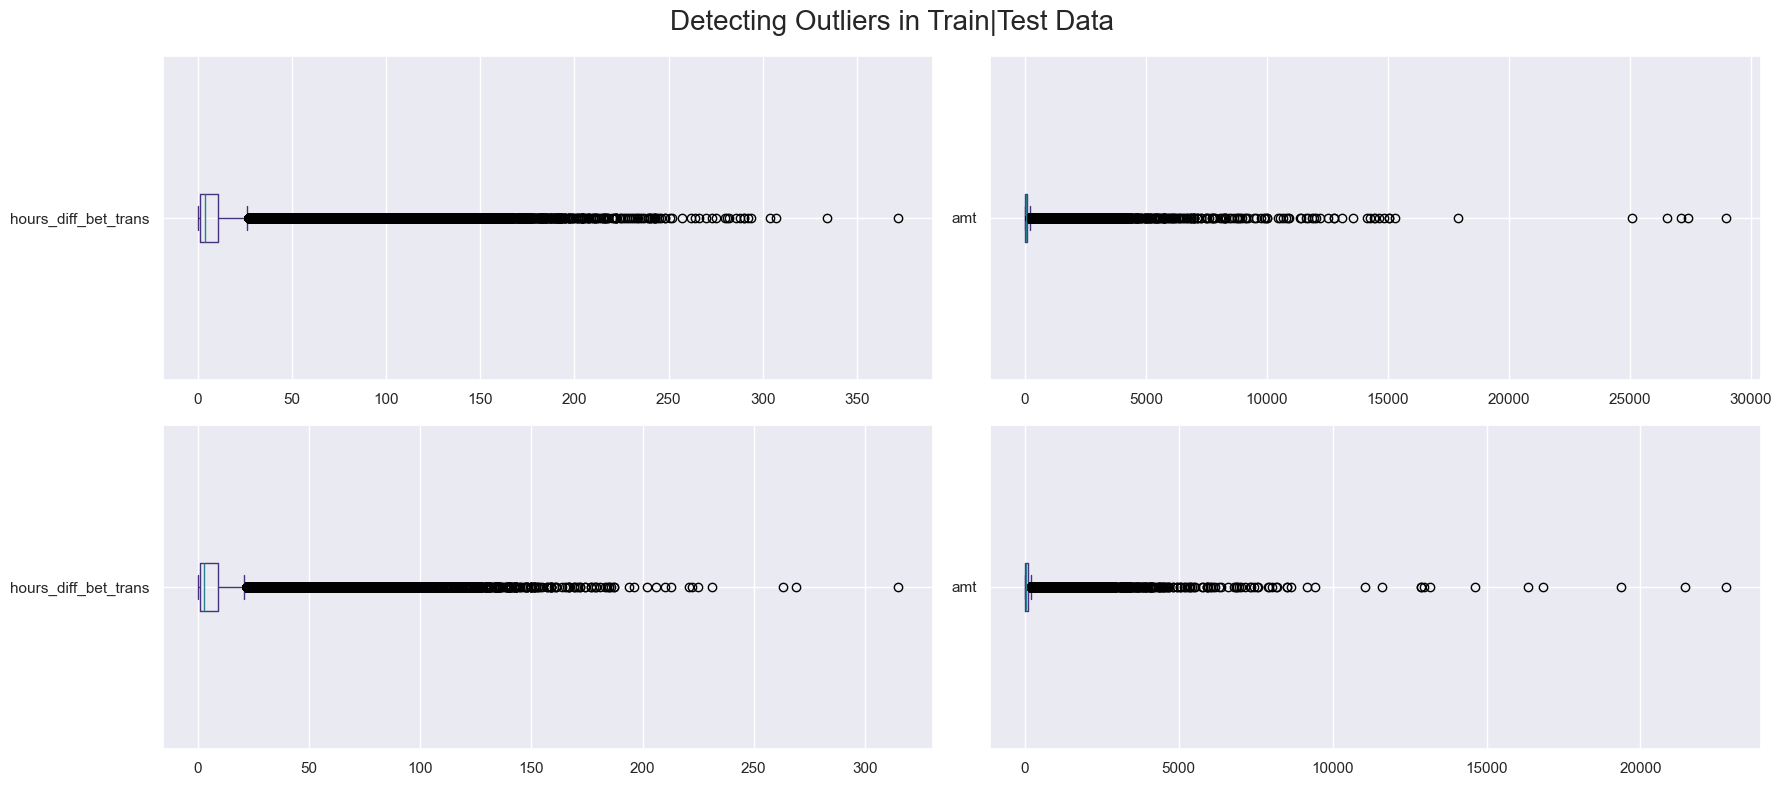

In [68]:
datasets={'x_train':x_train,'x_test':x_test}
cols=['hours_diff_bet_trans','amt']
count_outliers(cols)
boxplot_outlier(datasets)

In [69]:
#aplying log scale
for col in cols:
    x_train[col]=np.log1p(x_train[col])
    x_test[col]=np.log1p(x_test[col])

Outliers In hours_diff_bet_trans: 222
Outliers In amt: 818


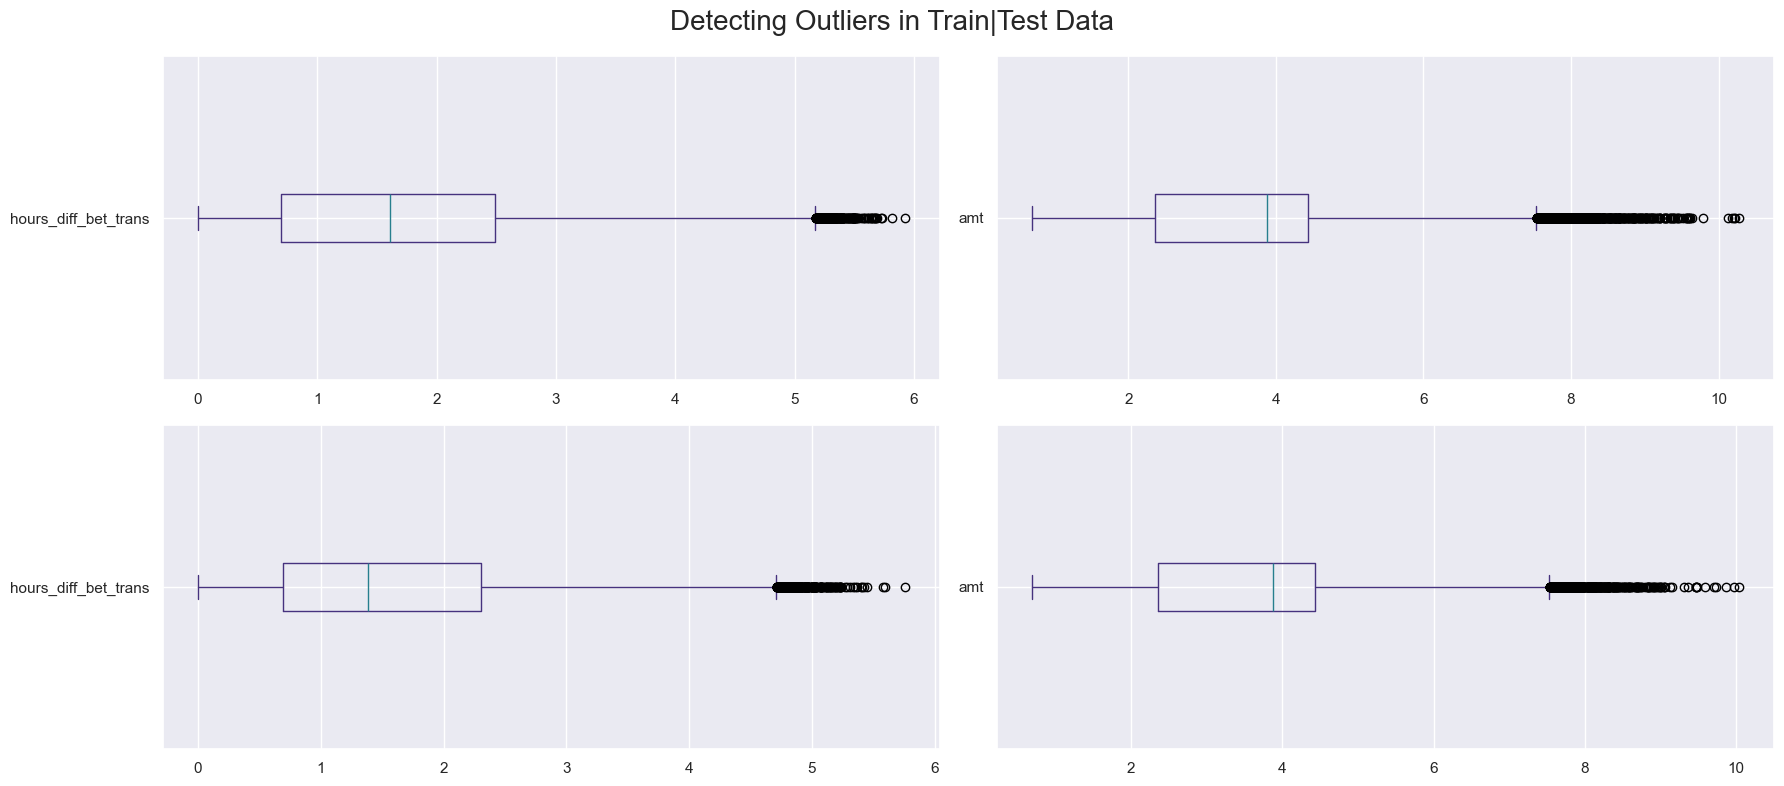

In [70]:
count_outliers(cols)
boxplot_outlier(datasets)

#### As we can see the log transformation make the distribution more symmetric and reduced the impact of extreme values (we did not removed them).Also we can deal with this data seperately.But fro now,log functions are commonly used to handle right-skewed distributions.after applying our model we can revert data with exp.function to recover the actual data. 

In [72]:
scaler=StandardScaler().fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

# Model Building

#### we want to avoid false negative as much as possible.A false negative case means that fraud-postive transaction is assesed to genuine transaction , In this use case false positive (a genuine transaction,in this use as fraud - positive)are not as important as preventing a fraud.so our focus is about(RECALL)

In [141]:
#Let's try our model without handling the imbalanced data of fraud detection

In [155]:
evl_models={'Logistic Regression':LogisticRegression(random_state=10),
           'Decision Tree':DecisionTreeClassifier(random_state=10),
          'Random Forest':RandomForestClassifier(random_state=10)}

In [169]:
def evl_model(xtrain,ytrain,xtest,ytest):
    sns.set(rc={'figure.figsize':(18,6)})
    i=0
    for name,model in evl_models.items():
        fig,axs=plt.subplots(1,2)
        print('Model:'+name)
        print('_'*30)
        start=time()
        model.fit(xtrain,ytrain)
        y_pred=model.predict(xtest)
        end=time()
        #confusion matrix
        cm=confusion_matrix(ytest,y_pred,labels=model.classes_)
        cmd=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        cmd.plot(colorbar=False,ax=axs[i])
        axs[i].grid(False)
        #AUC-ROC curve
        y_proba=model.predict_proba(xtest)
        fpr,tpr,_=roc_curve(ytest,y_proba[:,1])
        roc_display=RocCurveDisplay(fpr=fpr,tpr=tpr).plot(ax=axs[i+1])
        axs[i+1].plot([0,1],[1,0],color='g')
        plt.tight_layout()
        plt.show()
        #we focus on recall = TP/TP+FN
        #such that it's score that model predict (non-fraud) while it's fraud
        print('Recall Score: {}\nPrecision: {}\nF1-Score: {}\nAccuracy Score: {}\nAUC Score: {}\nRunning Time: {} Mins'.format(recall_score(ytest,y_pred),precision_score(ytest,y_pred),f1_score(ytest,y_pred),accuracy_score(ytest,y_pred),roc_auc_score(ytest,y_proba[:,1]),round((end-start)/60.0,2)))
        print('*'*30)
        
    

Model:Logistic Regression
______________________________


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


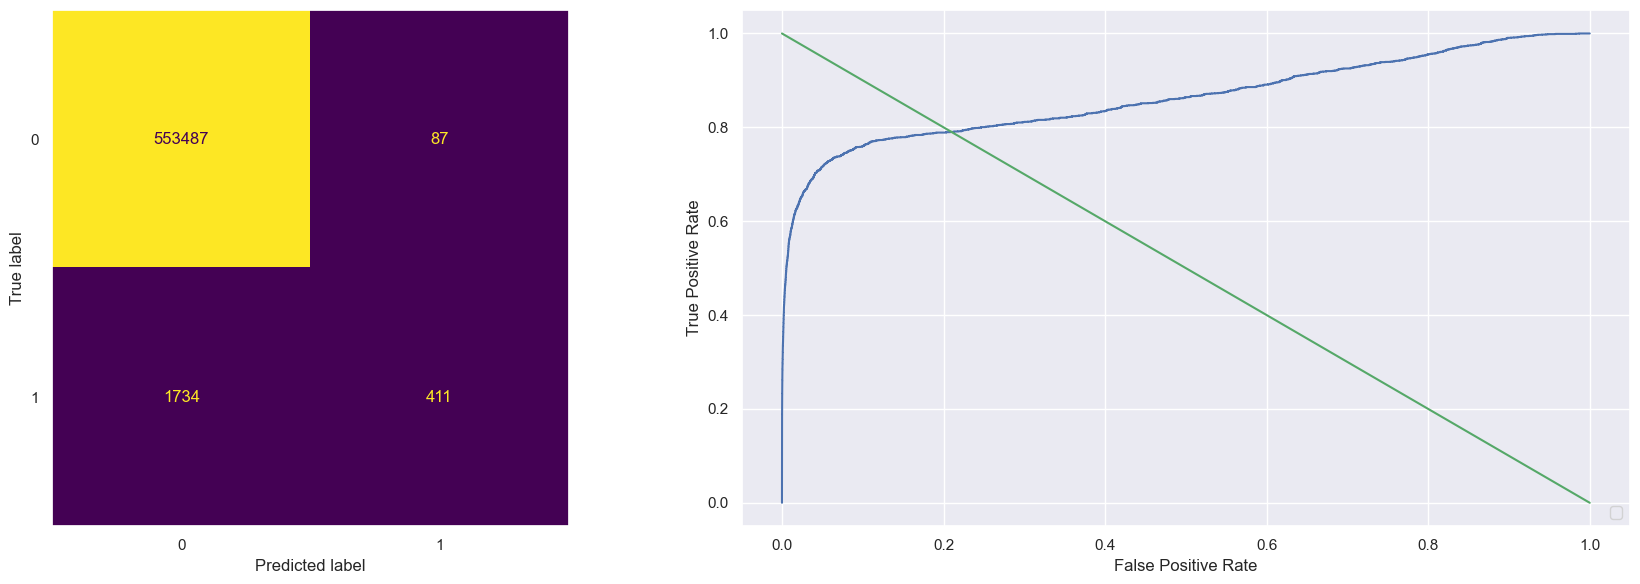

Recall Score: 0.1916083916083916
Precision: 0.8253012048192772
F1-Score: 0.3110102156640182
Accuracy Score: 0.9967231640451379
AUC Score: 0.8631324813540742
Running Time: 0.05 Mins
******************************
Model:Decision Tree
______________________________


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


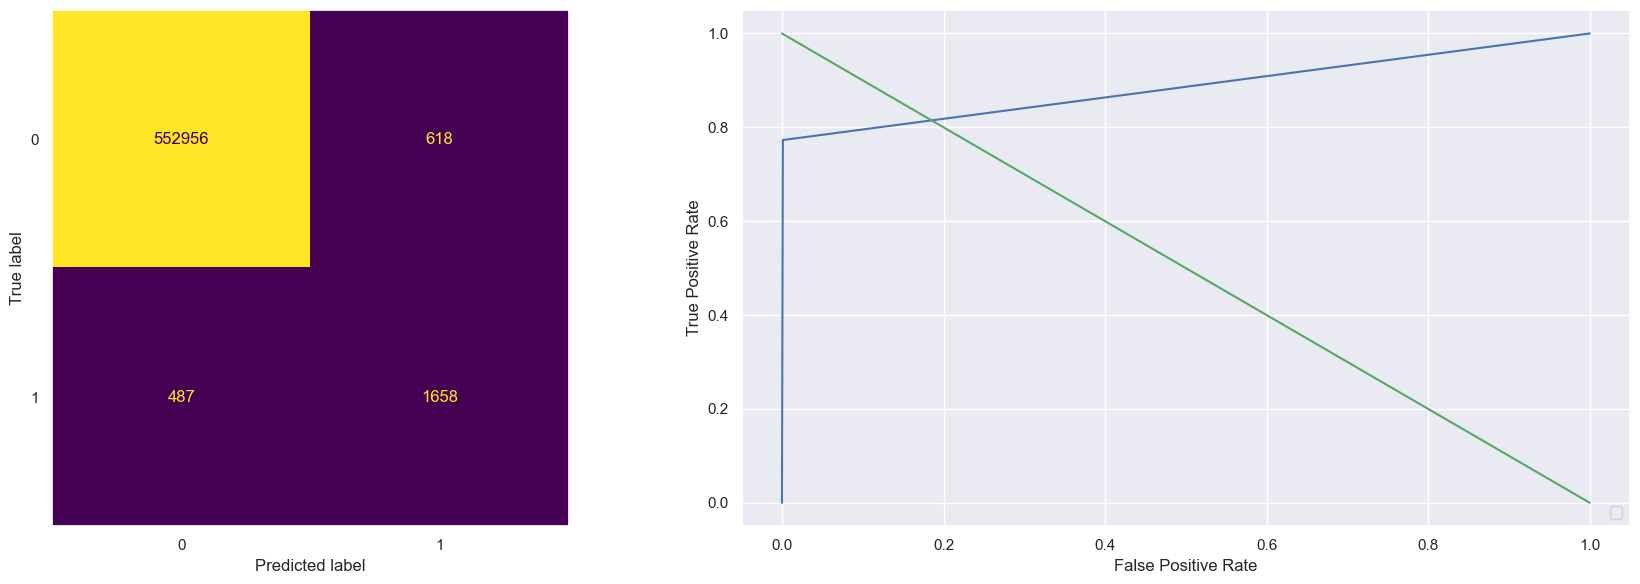

Recall Score: 0.772960372960373
Precision: 0.7284710017574693
F1-Score: 0.7500565482922417
Accuracy Score: 0.9980115849916954
AUC Score: 0.8859219955246865
Running Time: 0.22 Mins
******************************
Model:Random Forest
______________________________


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


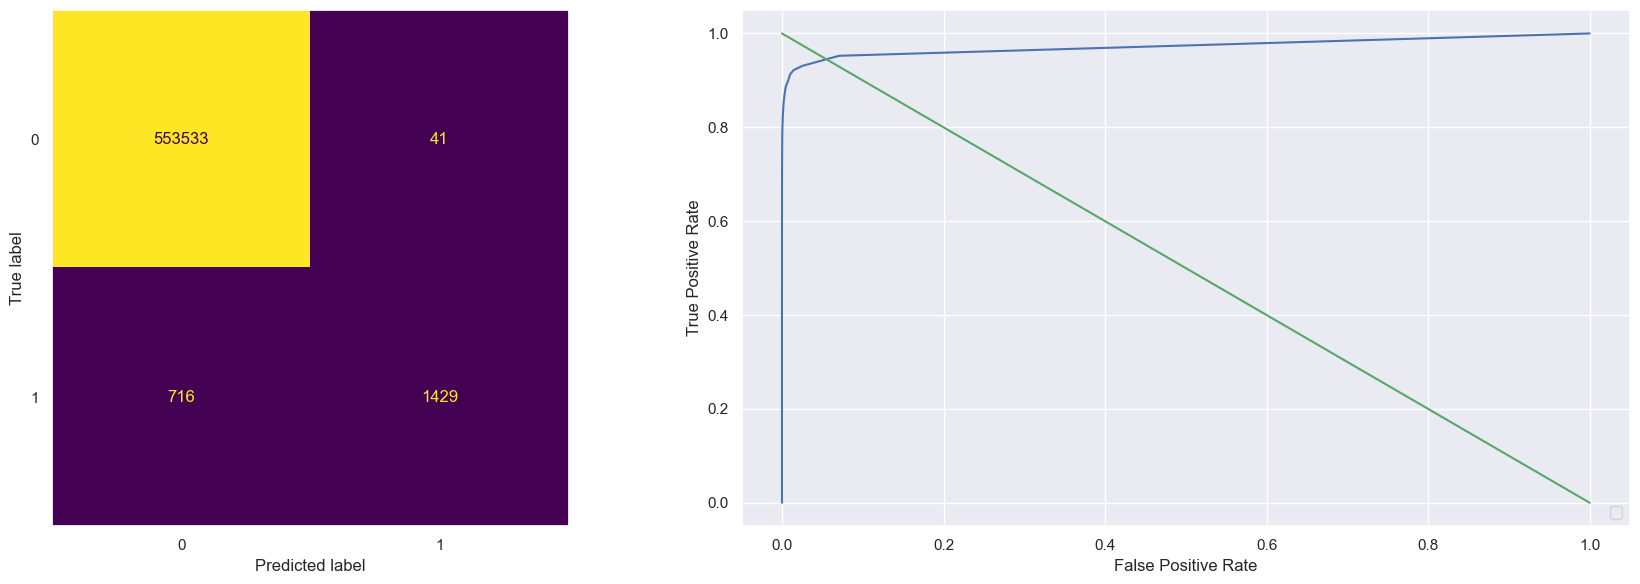

Recall Score: 0.6662004662004662
Precision: 0.972108843537415
F1-Score: 0.7905947441217152
Accuracy Score: 0.9986378007590166
AUC Score: 0.9728142022279753
Running Time: 4.71 Mins
******************************


In [171]:
evl_model(x_train,y_train,x_test,y_test)

### Conclusion(From Imbalanced Data)
- Logistic Regression:Gives a very weak recall accuracy
- Decision Tree:Give the Highes recall accuracy but low precision
- Random Forest:Gives high recall accuracy and high precision
- Note:Our Focus is not on model accuracy(Confusion matrix accuracy) TP+TN/TP+TN+FP+FN,Since we Focus on best accuracy for model to predict the real fraud transaction and don't predict non-fraud and we detect it from (True positive Rate 'Recall')